In [2]:
import argparse
from model_trainers.trainer import *
from dataloaders.dataloading import *
import torch.nn as nn
from torch import optim
from util.search_util import *
from dataloaders.custom_dataloader import *
from models.model_mlp import *
from models.model_small import *
import os
import time
from dataloaders.get_all_samples import *
from dataloaders.imbalanced_dataloader import *
from sklearn.manifold import TSNE

/Users/arghasreebanerjee/opt/anaconda3/envs/XAI_week1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial investigation

In [1]:
# Get the training data
# Select a random sample from the training data
# Check the sample's z score
# Check if the sample is an outlier or inlier 
# Get a pair of outlier and inlier
# Retrain the model with this new pair  
# Check the confidence score of the model before and after retraining


In [67]:
def visualize_outlier(mis, cor):
    plt.figure(figsize=(8, 6))
    plt.boxplot([mis, cor], labels=['Misclassified', 'Correctly Classified'])
    plt.title('Range Comparison: Misclassified vs Correctly Classified')
    plt.ylabel('Values')
    plt.show()

In [70]:
def find_z_scores(train_loader, model):
    mis = []
    cor = []
    for batch in train_loader:
        data, target = batch
        mean = data.mean()
        std = data.std()
        for i in range(data.size(0)):
            output = model(data[i])
            z_score = (data[i] - mean) / std
            if output.argmax() == target[i]:
                cor.append(z_score.mean())
            else:
                mis.append(z_score.mean())
            
    visualize_outlier(mis, cor)
    


In [ ]:
def visualize_dataset(train_loader, model):
    mis = []
    cor = []
    for batch in train_loader:
        data, target = batch

        for i in range(data.size(0)):
            output = model(data[i])

            if output.argmax() == target[i]:
                cor.append(data[i])
            else:
                mis.append(data[i])
            
    # Use t-SNE to visualize the dataset
    all_imgs = np.array(mis + cor)  # shape: (N, 1, 28, 28)
    all_imgs = all_imgs.reshape(all_imgs.shape[0], -1)  # shape: (N, 784)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_imgs)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:len(mis), 0], tsne_results[:len(mis), 1], c='red', label='Misclassified')
    plt.scatter(tsne_results[len(mis):, 0], tsne_results[len(mis):, 1], c='blue', label='Correctly Classified')
    plt.legend()
    plt.show()

In [ ]:
def check_outlier(train_loader, model):
    correct_sample = None
    incorrect_sample = None
    
    # Select a random sample from the training data
    batch = next(iter(train_loader))  # batch[0] is the data, batch[1] is the labels
    print(f'Batch (only images) shape: {batch[0].shape}')
    
    model.eval()
    with torch.no_grad():
        while correct_sample is None or incorrect_sample is None:
            index = torch.randint(0, batch[0].size(0), (1,)).item()
            sample = batch[0][index]  # select a random image from the batch
            label = batch[1][index]
            print(f'Sample shape: {sample.shape}')

            # Check the sample's z score
            z_score = (sample - batch[0].mean()) / batch[0].std()

            print('Z-score =', z_score.mean(), 'Std =', z_score.std())
                
            output = model(sample)
            # confidence = torch.softmax(output, dim=1)
            # print(f'Confidence = {confidence.max()}')
            
            if output.argmax() == label:
                correct_sample = sample
                correct_sample = (correct_sample, label)
                print("Sample is Correctly Classified")
            else:
                incorrect_sample = sample
                incorrect_sample = (incorrect_sample, label)
                print("Sample is Misclassified")


            # Check if the sample is an outlier or inlier
            if abs(z_score.mean()) > 2:
                print("Sample is Outlier")
            else:
                print("Sample is Inlier")
                
        
    return correct_sample, incorrect_sample

## Run these

In [116]:
directory = "/Users/arghasreebanerjee/PycharmProjects/XAI_hypernetwork"
batch_size = 100
random_seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
weight_decay = 0.0001
lr_decay = 0.1
no_model = False
model_directory = directory + f'/models/MLP/model_weights_mnist.pth'

In [120]:
train_loader, valid_loader, test_loader = data_loader_MNIST(directory=directory+'/data',
                                                            batch_size=batch_size,
                                                            random_seed=random_seed,
                                                            small=False,
                                                            shuffle=False)

image, _ = next(iter(train_loader))
model = MLP(num_classes=10, input_size=image.size()[1:])

model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)


if no_model:
    _, _, model, _, _ = train(train_loader, None, model,  # validation_data = None
                                                epochs=2,
                                                criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    torch.save(model.state_dict(), model_directory)
else:
    model.load_state_dict(torch.load(model_directory, 
                                 map_location=torch.device(device)))
    
state_dict = copy.deepcopy(model.state_dict())
    

Total batches = 600


## More investigations

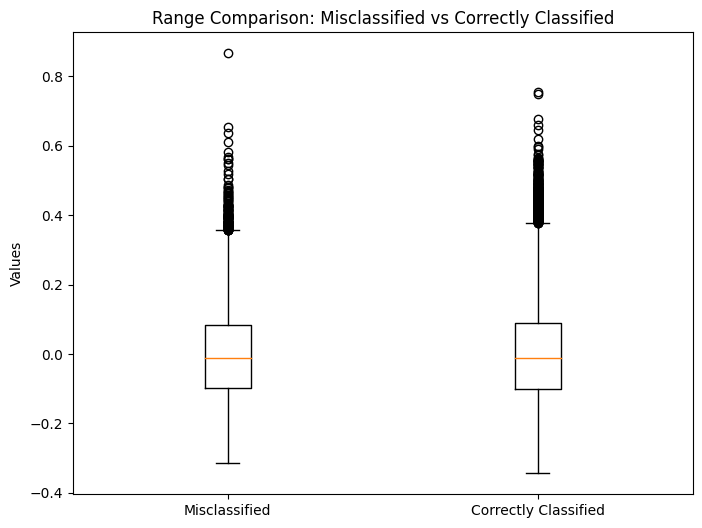

In [ ]:
find_z_scores(train_loader, model) 
## SSIM - structural outlier
# perclass geometric median 

In [ ]:
visualize_dataset(train_loader, model)

In [ ]:
correct_sample, incorrect_sample = check_outlier(train_loader, model)

In [39]:

def check_confidence(correct_sample, incorrect_sample, ep):
    # Checking confidence of the model before training 
    correct_image, correct_label = correct_sample
    incorrect_image, incorrect_label = incorrect_sample

    # Check confidence before training
    model.eval()
    with torch.no_grad():
        correct_output = model(correct_image.unsqueeze(0))
        incorrect_output = model(incorrect_image.unsqueeze(0))
        
        correct_confidence = torch.softmax(correct_output, dim=1)
        incorrect_confidence = torch.softmax(incorrect_output, dim=1)
        
        print(f'Before training - Correct sample confidence: {correct_confidence.max().item():.4f}')
        print(f'Before training - Incorrect sample confidence: {incorrect_confidence.max().item():.4f}')

    # Create dataloaders for training
    def create_sample_dataloader(samples, batch_size=2):
        """Create a dataloader from a list of (image, label) tuples"""
        dataset = []
        for image, label in samples:
            dataset.append((image, label))
        
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Create dataloaders
    both_samples = [correct_sample, incorrect_sample]
    incorrect_only = [incorrect_sample]

    both_loader = create_sample_dataloader(both_samples)
    incorrect_loader = create_sample_dataloader(incorrect_only)

    # Train model on both samples
    model.train()
    print("\nTraining on both correct and incorrect samples...")
    for epoch in range(ep):  
        for batch_idx, (data, target) in enumerate(both_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # if batch_idx == 0:
            #     print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    # Check confidence after training on both samples
    model.eval()
    with torch.no_grad():
        correct_output = model(correct_image.unsqueeze(0))
        incorrect_output = model(incorrect_image.unsqueeze(0))
        
        correct_confidence = torch.softmax(correct_output, dim=1)
        incorrect_confidence = torch.softmax(incorrect_output, dim=1)
        
        print(f'\nAfter training on both samples:')
        print(f'Correct sample confidence: {correct_confidence.max().item():.4f}')
        print(f'Incorrect sample confidence: {incorrect_confidence.max().item():.4f}')

    # Reset model to original state
    model.load_state_dict(torch.load(model_directory, map_location=torch.device(device)))

    # Train model on incorrect sample only
    model.train()
    print("\nTraining on incorrect sample only...")
    for epoch in range(5):  # Train for 5 epochs
        for batch_idx, (data, target) in enumerate(incorrect_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # if batch_idx == 0:
            #     print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    # Check confidence after training on incorrect sample only
    model.eval()
    with torch.no_grad():
        correct_output = model(correct_image.unsqueeze(0))
        incorrect_output = model(incorrect_image.unsqueeze(0))
        
        correct_confidence = torch.softmax(correct_output, dim=1)
        incorrect_confidence = torch.softmax(incorrect_output, dim=1)
        
        print(f'\nAfter training on incorrect sample only:')
        print(f'Correct sample confidence: {correct_confidence.max().item():.4f}')
        print(f'Incorrect sample confidence: {incorrect_confidence.max().item():.4f}')


In [40]:
ep = 1  # epochs for training on the samples
check_confidence(correct_sample, incorrect_sample, ep)

Before training - Correct sample confidence: 0.9888
Before training - Incorrect sample confidence: 0.9998

Training on both correct and incorrect samples...

After training on both samples:
Correct sample confidence: 0.9936
Incorrect sample confidence: 0.9999

Training on incorrect sample only...

After training on incorrect sample only:
Correct sample confidence: 0.9826
Incorrect sample confidence: 0.9996


**Summary**

Until now I have seen a change in confidence scores when re-training with only the correct sample and incorrect sample. I tried to see if there was a correlation with a sample's outlierishness and the ability of a model to predict the sample correctly. None was found. 

**Next Steps**:

> - Apply usual distillation loss (tries not to change the weights based on the old model's logits)
> - Generating based on the replay of synthetic training samples. 
    > To answer: 1. How the generation process of the synthetic samples depend on the model logits/acivations of the incorrect sample. 

## Next: Distillation Loss + Retraining

In [41]:

# Get a dataloader of the incorrect samples
def get_incorrect_samples(model, test_loader):
    images = []
    labels = []
    for batch in test_loader:
        data, target = batch
        output = model(data)
        y_pred = output.argmax(dim=1)
        indices = y_pred != target
        images.extend(data[indices])
        labels.extend(target[indices])
    
    from dataloaders.custom_dataloader import data_loader
    incorrect_loader = data_loader(images=images, 
                                   labels=labels, 
                                   batch_size=1, 
                                   shuffle=False)
    
    # tested to see if the old model misclassifies the incorrect samples
    # It does
    
    
    return incorrect_loader

In [42]:
# Make a new changable model with new optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = MLP(num_classes=10, input_size=image.size()[1:])
old_model_weights = copy.deepcopy(model.state_dict())
new_model_optimizer = torch.optim.SGD(new_model.parameters(), 
                                      lr=learning_rate, 
                                      weight_decay=weight_decay, 
                                      momentum=0.9)

new_model.load_state_dict(old_model_weights)
new_model.to(device)


# Apply distillation loss to the new model
from model_trainers.trainer import lwf_train
incorrect_loader = get_incorrect_samples(model, test_loader)

new_model = lwf_train(incorrect_loader,
              old_model=model, # old model
              new_model=new_model, 
              optimizer_new_model=new_model_optimizer,
              num_epochs=1, 
              temperature=2.0, 
              alpha=0.5, 
              lr=1e-3, 
              device=device)


torch.Size([1747, 10]) 1747
 Trainig new model --> epoch = 1 
torch.Size([1747, 10]) 1747


In [43]:
# Check the accuracy of the old model
model.eval()
with torch.no_grad():
    from model_trainers.trainer import predict, evaluate
    y_true, y_pred = predict(model, test_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the TEST set: {accuracy}')
    
    y_true, y_pred = predict(model, incorrect_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the INCORRECT set: {accuracy}')
    
    y_true, y_pred = predict(model, train_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the TRAIN set: {accuracy}')
    
print("--------------------------------")

# Check the accuracy of the new model
new_model.eval()
with torch.no_grad():
    from model_trainers.trainer import predict, evaluate
    y_true, y_pred = predict(new_model, test_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the TEST set: {accuracy}')
    
    y_true, y_pred = predict(new_model, incorrect_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the INCORRECT set: {accuracy}')
    
    y_true, y_pred = predict(new_model, train_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the TRAIN set: {accuracy}')

Accuracy of the old model for the TEST set: 0.8253
Accuracy of the old model for the INCORRECT set: 0.0
Accuracy of the old model for the TRAIN set: 0.8174814814814815
--------------------------------
Accuracy of the new model for the TEST set: 0.8254
Accuracy of the new model for the INCORRECT set: 0.029765311963365768
Accuracy of the new model for the TRAIN set: 0.8161481481481482


In [47]:
# Make a new changable model with new optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = MLP(num_classes=10, input_size=image.size()[1:])
old_model_weights = copy.deepcopy(model.state_dict())
new_model_optimizer = torch.optim.SGD(new_model.parameters(), 
                                      lr=learning_rate, 
                                      weight_decay=weight_decay, 
                                      momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

new_model.load_state_dict(old_model_weights)
new_model.to(device)


# Apply distillation loss to the new model
from model_trainers.trainer import lwf_train
incorrect_loader = get_incorrect_samples(model, test_loader)


_=train(incorrect_loader, 
                  validation_data=None, 
                  model=new_model, 
                  epochs=1, 
                  criterion=criterion, 
                  optimizer=new_model_optimizer, 
                  scheduler=scheduler)


------------------------ epoch = 1 -----------------------------
No validation data found. Checking training data accuracy instead .. 
Accuracy of val data is 0.5449341728677733



In [48]:
# Check the accuracy of the old model
model.eval()
with torch.no_grad():
    from model_trainers.trainer import predict, evaluate
    y_true, y_pred = predict(model, test_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the TEST set: {accuracy}')
    
    y_true, y_pred = predict(model, incorrect_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the INCORRECT set: {accuracy}')
    
    y_true, y_pred = predict(model, train_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the old model for the TRAIN set: {accuracy}')
    
print("--------------------------------")

# Check the accuracy of the new model
new_model.eval()
with torch.no_grad():
    from model_trainers.trainer import predict, evaluate
    y_true, y_pred = predict(new_model, test_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the TEST set: {accuracy}')
    
    y_true, y_pred = predict(new_model, incorrect_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the INCORRECT set: {accuracy}')
    
    y_true, y_pred = predict(new_model, train_loader)
    accuracy = evaluate(y_true, y_pred)
    print(f'Accuracy of the new model for the TRAIN set: {accuracy}')

Accuracy of the old model for the TEST set: 0.8253
Accuracy of the old model for the INCORRECT set: 0.0
Accuracy of the old model for the TRAIN set: 0.8174814814814815
--------------------------------
Accuracy of the new model for the TEST set: 0.4077
Accuracy of the new model for the INCORRECT set: 0.5449341728677733
Accuracy of the new model for the TRAIN set: 0.4094259259259259


**Summary yet:**

- Distillation loss indead helps vs only trying the re-training loss.
- Retraining however helps to correct more incorrect samples.
- When trying to distill the test performance improves, incorrect loader performance improves, but training performance decreases.

## Next: Retraining with one more training sample

In [55]:
len(train_loader.dataset)

60000

In [108]:
def get_cor_plus_incor_loader(model, incorrect_loader, train_loader):
    """Here the correct and the incorrect samples would be combined in a batch 
    """
    # From the incorrect loader, get the label
    # Send the label to the train loader and get a sample of the same label
    # Check if the sample is correctly classified
    # If it is not, reget the sample 
    # If is is add to with the incorrect loader sample and make it into a batch 
    def select_training_sample(train_loader, label):
        random_index = random.randint(0, len(train_loader.dataset) - 1)
        sample = train_loader.dataset[random_index] 
        if sample[1] == label.item():
            return sample
        else:
            return select_training_sample(train_loader, label)

    batches = []
    for sample in incorrect_loader:
        label = sample[1]
        
        # Get a random sample from the train loader with the same label
        train_sample = select_training_sample(train_loader, label)
        train_label = torch.tensor([train_sample[1]], dtype=torch.long).to(device)
        batches.append((sample[0][0], sample[1]))
        batches.append((train_sample[0], train_label))
        
    loader = torch.utils.data.DataLoader(batches, batch_size=2, shuffle=False)  
    # Make sure shuffle is False so that the samples from the same traget class in the same batch 
    # print(len(loader), len(incorrect_loader))  # these numbers should match -> it matches
    
    return loader
        

In [126]:
# Create the incorrect loader
incorrect_loader = get_incorrect_samples(model, test_loader)


def run(model, incorrect_loader, train_loader, epochs=1):
    # Create the incorrect + correct sample in a batch loader
    cor_plus_incor_loader = get_cor_plus_incor_loader(model, incorrect_loader, train_loader)
    
    # Train the model on the incorrect + correct sample loader
    model.load_state_dict(state_dict)
    for epoch in range(epochs):
            # print(f'\n---------- epoch = {epoch + 1} ----------')
            model.train()
            both_acc_test=[]
            both_acc_incor=[]
            both_acc_train=[]
            for i, x_batch in enumerate(cor_plus_incor_loader):
                if i==10:
                    break
                # print(f'----Batch {i}----')
                images, labels = x_batch
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.nn.functional.one_hot(labels, num_classes=10).float().squeeze(1)
            
                y_pred = model(images)
                loss = criterion(y_pred.to(device), labels).to(device)
                optimizer.zero_grad()
                loss.backward(retain_graph = True)
                optimizer.step()
                
                y_true, y_pred = predict(model, test_loader)
                accuracy = evaluate(y_true, y_pred)
                both_acc_test.append(accuracy)

                y_true, y_pred = predict(model, incorrect_loader)
                accuracy = evaluate(y_true, y_pred)
                both_acc_incor.append(accuracy)
                
                y_true, y_pred = predict(model, train_loader)
                accuracy = evaluate(y_true, y_pred)
                both_acc_train.append(accuracy)
                
    
    # Train the model on the incorrect sample loader
    model.load_state_dict(state_dict)
    for epoch in range(epochs):
            # print(f'\n---------- epoch = {epoch + 1} ----------')
            model.train()
            acc_incor=[]
            acc_test=[]
            acc_train=[]
            for i, x_batch in enumerate(incorrect_loader):
                if i==10:
                    break
                # print(f'----Batch {i}----')
                images, labels = x_batch
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.nn.functional.one_hot(labels, num_classes=10).float().squeeze(1)
            
                y_pred = model(images)
                loss = criterion(y_pred.to(device), labels).to(device)
                optimizer.zero_grad()
                loss.backward(retain_graph = True)
                optimizer.step()
                
                y_true, y_pred = predict(model, test_loader)
                accuracy = evaluate(y_true, y_pred)
                acc_test.append(accuracy)
                
                y_true, y_pred = predict(model, incorrect_loader)
                accuracy = evaluate(y_true, y_pred)
                acc_incor.append(accuracy)
                
                y_true, y_pred = predict(model, train_loader)
                accuracy = evaluate(y_true, y_pred)
                acc_train.append(accuracy)
                
    return both_acc_test, both_acc_incor, both_acc_train, acc_test, acc_incor, acc_train
                



ValueError: num must be an integer with 1 <= num <= 2, not 3

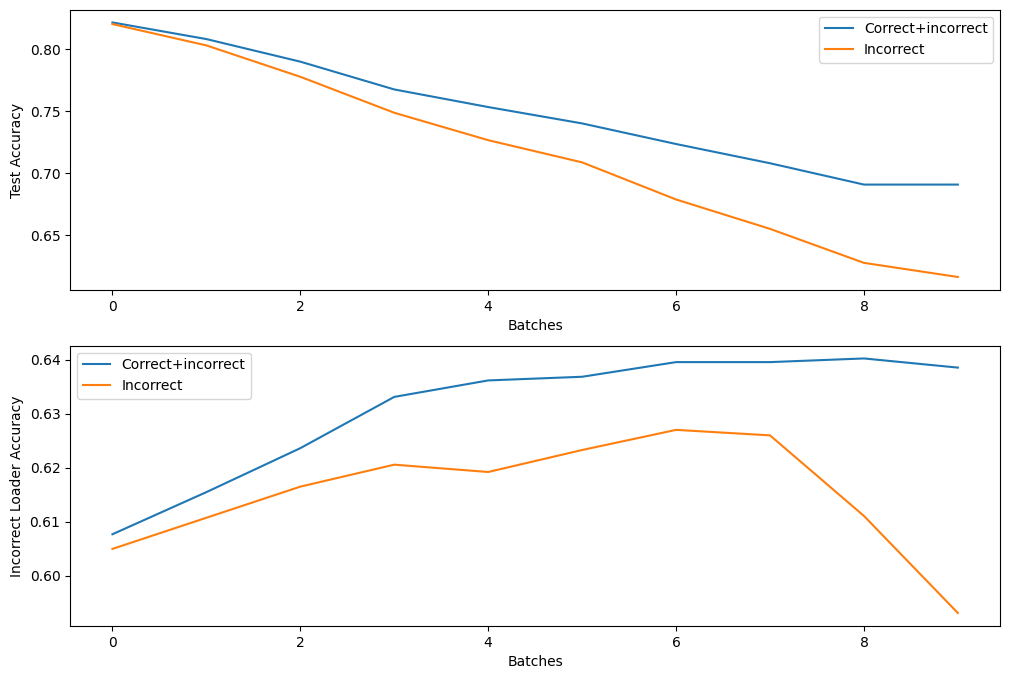

In [129]:
for i in range(10):
    both_acc_test, both_acc_incor, both_acc_train, acc_test, acc_incor, acc_train = run(model, incorrect_loader, train_loader)
    import matplotlib.pyplot as plt

    # Plotting the accuracy lists in the same plot
    if i==0:
        plt.figure(figsize=(12, 8))

    # Plot both_acc_test, both_acc_incor, both_acc_train in the same subplot
    if i==0:
        plt.subplot(2, 1, 1)
    plt.plot(both_acc_test, label='Correct+incorrect')
    plt.plot(acc_test, label='Incorrect')
    plt.xlabel('Batches')
    plt.ylabel('Test Accuracy')
    plt.legend()
    
    if i==0:
        plt.subplot(2, 1, 2)
    plt.plot(both_acc_incor, label='Correct+incorrect')
    plt.plot(acc_incor, label='Incorrect')
    plt.xlabel('Batches')
    plt.ylabel('Incorrect Loader Accuracy')
    plt.legend()
    
    if i==0:
        plt.subplot(2, 1, 3)
    plt.plot(both_acc_train, label='Correct+incorrect')
    plt.plot(acc_train, label='Correct')
    plt.xlabel('Batches')
    plt.ylabel('Train Accuracy')
    plt.legend()


plt.tight_layout()
plt.show()


Caveats after talking to matthew:
- The letting go of learned weights would be controlled by 80% correct samples while training in the later stages. 
- But the letting go of learned weights would be controlled by 0% correct samples during test time adaption. This is what causing the complete letting go/catastrophic forgetting. 
- However if we have one correct sample along with the incorrect sample, then the letting go would not be that much, but it would still happen.
- How to avoid this?
- This exact research is going on, so I cannot do anything about it right now. 
So instead do what? 
- Mostly my approach is a replay based method